In [1]:
#!source ~/scripts/renew_cms.sh
import processor.FCNC_FR_validation as fr
import matplotlib.pyplot as plt
import awkward as ak

from coffea import processor, hist
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.analysis_tools import Weights, PackedSelection

import numpy as np
import pandas as pd
from yahist import Hist1D, Hist2D

# this is all very bad practice
from Tools.objects import *
from Tools.basic_objects import *
from Tools.cutflow import *
from Tools.config_helpers import *
from Tools.triggers import *
from Tools.btag_scalefactors import *
from Tools.lepton_scalefactors import *
from Tools.nano_mapping import make_fileset, nano_mapping
from processor.meta_processor import get_sample_meta
from plots.helpers import makePlot, scale_and_merge

In [2]:
from klepto.archives import dir_archive
from processor.default_accumulators import desired_output, add_processes_to_output, dataset_axis, pt_axis, eta_axis

from Tools.helpers import get_samples
from Tools.config_helpers import redirector_ucsd, redirector_fnal
from Tools.nano_mapping import make_fileset
import glob

year = 2018

fileset = {}
for file in glob.glob("/hadoop/cms/store/user/ksalyer/FCNC_NanoSkim/fcnc_v3/TTJets_TuneCUETP8M2T4_13TeV-amcatnloFXFX-pythia8_RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_NANOAODSIM_fcnc_v3/*.root"):
    fileset[file[file.find('output_'):file.find('.root')]] = [file]
#fileset = make_fileset(['QCD'], samples, redirector=redirector_ucsd, small=True) 
add_processes_to_output(fileset, desired_output)
pt_axis_mu = hist.Bin("pt", r"$p_{T}$ (GeV)", [10., 15., 25.,  35., 50.])
eta_axis_mu =  hist.Bin("eta", r"$p_{T}$ (GeV)", [0, 1.2, 2.1, 2.4])
pt_axis_e = hist.Bin("pt", r"$p_{T}$ (GeV)", [0, 25., 35., 45., 65., 100])
eta_axis_e =  hist.Bin("eta", r"$p_{T}$ (GeV)", [0, 1.479, 2.5])

desired_output.update({
    "EE_SR": processor.column_accumulator(np.zeros(shape=(1,))),
    "EE_CR": processor.column_accumulator(np.zeros(shape=(1,))),
    "EE_CR_weighted": processor.column_accumulator(np.zeros(shape=(1,))),
    "MM_SR": processor.column_accumulator(np.zeros(shape=(1,))),
    "MM_CR": processor.column_accumulator(np.zeros(shape=(1,))),
    "MM_CR_weighted": processor.column_accumulator(np.zeros(shape=(1,))),
    "EM_SR": processor.column_accumulator(np.zeros(shape=(1,))),
    "EM_CR": processor.column_accumulator(np.zeros(shape=(1,))),
    "EM_CR_weighted": processor.column_accumulator(np.zeros(shape=(1,))),
    "ME_SR": processor.column_accumulator(np.zeros(shape=(1,))),
    "ME_CR": processor.column_accumulator(np.zeros(shape=(1,))),
    "ME_CR_weighted": processor.column_accumulator(np.zeros(shape=(1,)))
})

exe_args = {
    'workers': 16,
    'function_args': {'flatten': False},
    "schema": NanoAODSchema,
    "skipbadfiles": True,
}
exe = processor.futures_executor


print ("I'm running now")

output = processor.run_uproot_job(
    fileset,
    "Events",
    fr.nano_analysis(year=year, variations=[], accumulator=desired_output),
    exe,
    exe_args,
    chunksize=250000
)


#get weights and scale data
#meta = get_sample_meta(fileset, samples)
#my_hists = {}
#my_hists['single_mu_fakeable'] = scale_and_merge(output['single_mu_fakeable'], meta, fileset, nano_mapping)
#my_hists['single_mu'] = scale_and_merge(output['single_mu'], meta, fileset, nano_mapping)

I'm running now


Preprocessing:   0%|          | 0/43 [00:00<?, ?file/s]

Processing:   0%|          | 0/43 [00:00<?, ?chunk/s]

/home/users/cmcmahon/miniconda3/envs/coffeadev/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference target for Electron_photonIdx => Photon
  warnings.warn(
/home/users/cmcmahon/miniconda3/envs/coffeadev/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference target for FatJet_genJetAK8Idx => GenJetAK8
  warnings.warn(
/home/users/cmcmahon/miniconda3/envs/coffeadev/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference target for FatJet_subJetIdx1 => SubJet
  warnings.warn(
/home/users/cmcmahon/miniconda3/envs/coffeadev/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference target for FatJet_subJetIdx2 => SubJet
  warnings.warn(
/home/users/cmcmahon/miniconda3/envs/coffeadev/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:194: RuntimeWarning: Missing c

TypeError: cannot perform reduce with flexible type

Failed processing file: /hadoop/cms/store/user/ksalyer/FCNC_NanoSkim/fcnc_v3/TTJets_TuneCUETP8M2T4_13TeV-amcatnloFXFX-pythia8_RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_NANOAODSIM_fcnc_v3/output_40.root (0-125)

In [ ]:
EE_CR = output["EE_CR"]
EE_SR = output["EE_SR"]

def make_yahist(x):
    x_axis_0 = x.axes()[0].name
    x_axis_1 = x.axes()[1].name
    #breakpoint()
    yahist_x = Hist2D.from_bincounts(x.values()[()].T, (x.axis(x_axis_0).edges(), x.axis(x_axis_1).edges()))
    return yahist_x

def divide_2D_hist(x, y):
    x_axis_0 = x.axes()[0].name
    x_axis_1 = x.axes()[1].name
    y_axis_0 = y.axes()[0].name
    y_axis_1 = y.axes()[1].name
    yahist_x = Hist2D.from_bincounts(x.values()[()].T, (x.axis(x_axis_0).edges(), x.axis(x_axis_1).edges()))
    yahist_y = Hist2D.from_bincounts(y.values()[()].T, (y.axis(y_axis_0).edges(), y.axis(y_axis_1).edges()))
    return yahist_x.divide(yahist_y)


In [ ]:
EE_SR

In [ ]:
regions = ["EE_SR", "EE_CR", "EE_CR_weighted", "MM_SR", "MM_CR", "MM_CR_weighted", "ME_SR", "ME_CR", "ME_CR_weighted", "EM_SR", "EM_CR", "EM_CR_weighted"]
counts = [output[r] for r in regions]

for n in range(len(regions)):
    print("region: {} \t count {}".format(regions[n], counts[n]))

In [ ]:
import yahist

bins_pt = np.array([10., 15., 20., 25., 35., 50, 70])
bins_eta = np.array([0, 0.8, 1.479, 2.5])

electron_counts_2018 = np.array([
    [0., 0., 0.],
    [0.469227, 0.522789, 0.407835],
    [0.143496, 0.201734, 0.146049],
    [0.0811412, 0.081194, 0.150573],
    [0.0798284, 0.125701, 0.157778],
    [0.0940064, 0.172235, 0.169947]
])

muon_counts_2018 = np.array([
    [0., 0., 0.],
    [0.485363, 0.548621, 0.662505],
    [0.169757, 0.227283, 0.273878],
    [0.0570671, 0.0852324, 0.0950307],
    [0.0449928, 0.0530749, 0.0711829],
    [0.0398129, 0.0531309, 0.046544]
])

electron_counts_2016 = np.array([
    [0., 0., 0.],
    [0.3789, 0.3942, 0.4086],
    [0.1643, 0.1805, 0.1628],
    [0.1226, 0.1298, 0.1335],
    [0.1568, 0.1756, 0.1381],
    [0.2846, 0.1756, 0.2120]
])

muon_counts_2016 = np.array([
    [0.3940, 0.4297, 0.4809],
    [0.1301, 0.1486, 0.1959],
    [0.0885, 0.0979, 0.1375],
    [0.0805, 0.0878, 0.1090],
    [0.0785, 0.0788, 0.1008],
    [0.0793, 0.0707, 0.1073]
])

electron_2018 = Hist2D.from_bincounts(electron_counts_2018.T, (bins_pt, bins_eta))
electron_2016 = Hist2D.from_bincounts(electron_counts_2016.T, (bins_pt, bins_eta))
muon_2018 = Hist2D.from_bincounts(muon_counts_2018.T, (bins_pt, bins_eta))
muon_2016 = Hist2D.from_bincounts(muon_counts_2016.T, (bins_pt, bins_eta))


In [22]:
import pickle
pickle.dump(electron_2018, open("../data/fake_rate/FR_electron_2018.p", "wb"))
pickle.dump(electron_2016, open("../data/fake_rate/FR_electron_2016.p", "wb"))
pickle.dump(muon_2018, open("../data/fake_rate/FR_muon_2018.p", "wb"))
pickle.dump(muon_2016, open("../data/fake_rate/FR_muon_2016.p", "wb"))

Text(0.5, 1.0, 'Legacy Muon Fake Rate (2016)')

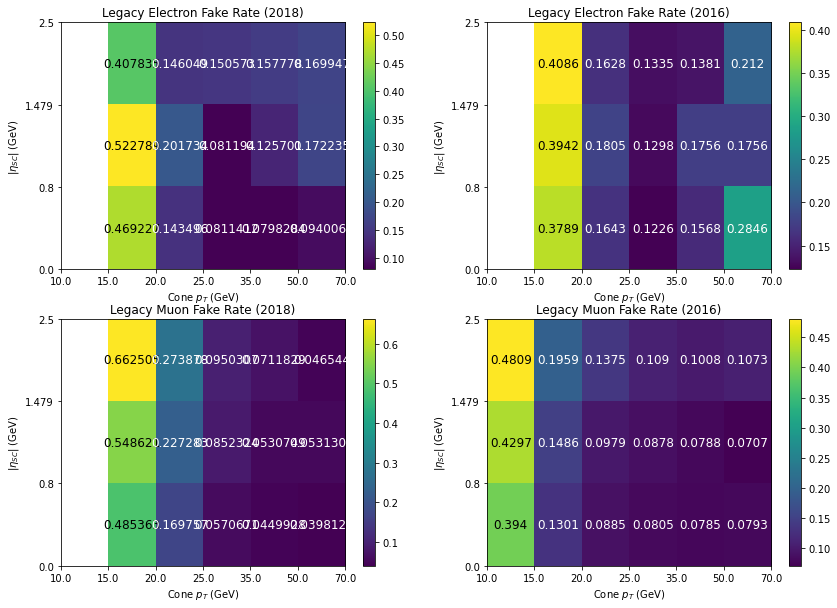

In [20]:
# float muonQCDMCFakeRate_IsoTrigs_legacy(float pt, float eta) {
#    if (pt>=10 && pt<15 && fabs(eta)>=0.000 && fabs(eta)<1.200) return 0.3940; // +-1.1%;
#    if (pt>=10 && pt<15 && fabs(eta)>=1.200 && fabs(eta)<2.100) return 0.4297; // +-1.3%;
#    if (pt>=10 && pt<15 && fabs(eta)>=2.100 && fabs(eta)<2.400) return 0.4809; // +-2.1%;

#    if (pt>=15 && pt<20 && fabs(eta)>=0.000 && fabs(eta)<1.200) return 0.1301; // +-1.4%;
#    if (pt>=15 && pt<20 && fabs(eta)>=1.200 && fabs(eta)<2.100) return 0.1486; // +-1.7%;
#    if (pt>=15 && pt<20 && fabs(eta)>=2.100 && fabs(eta)<2.400) return 0.1959; // +-2.8%;

#    if (pt>=20 && pt<25 && fabs(eta)>=0.000 && fabs(eta)<1.200) return 0.0885; // +-2.0%;
#    if (pt>=20 && pt<25 && fabs(eta)>=1.200 && fabs(eta)<2.100) return 0.0979; // +-2.4%;
#    if (pt>=20 && pt<25 && fabs(eta)>=2.100 && fabs(eta)<2.400) return 0.1375; // +-4.0%;

#    if (pt>=25 && pt<35 && fabs(eta)>=0.000 && fabs(eta)<1.200) return 0.0805; // +-2.3%;
#    if (pt>=25 && pt<35 && fabs(eta)>=1.200 && fabs(eta)<2.100) return 0.0878; // +-2.7%;
#    if (pt>=25 && pt<35 && fabs(eta)>=2.100 && fabs(eta)<2.400) return 0.1090; // +-4.6%;

#    if (pt>=35 && pt<50 && fabs(eta)>=0.000 && fabs(eta)<1.200) return 0.0785; // +-3.9%;
#    if (pt>=35 && pt<50 && fabs(eta)>=1.200 && fabs(eta)<2.100) return 0.0788; // +-4.7%;
#    if (pt>=35 && pt<50 && fabs(eta)>=2.100 && fabs(eta)<2.400) return 0.1008; // +-8.2%;

#    if (pt>=50 && pt<70 && fabs(eta)>=0.000 && fabs(eta)<1.200) return 0.0793; // +-8.6%;
#    if (pt>=50 && pt<70 && fabs(eta)>=1.200 && fabs(eta)<2.100) return 0.0707; // +-10.9%;
#    if (pt>=50 && pt<70 && fabs(eta)>=2.100 && fabs(eta)<2.400) return 0.1073; // +-17.2%;

#    if (pt>=70 && fabs(eta)>=0.000 && fabs(eta)<1.200) return 0.0748; // +-17.7%;
#    if (pt>=70 && fabs(eta)>=1.200 && fabs(eta)<2.100) return 0.0813; // +-19.4%;
#    if (pt>=70 && fabs(eta)>=2.100 && fabs(eta)<2.400) return 0.0930; // +-39.3%;
#    return 0.;
# }
fig, ax = plt.subplots(2, 2, figsize = (14,10))

electron_2018.plot(show_counts=True, equidistant='xy', ax=ax[0, 0])
ax[0, 0].set_xlabel(r'Cone $p_T$ (GeV)')
ax[0, 0].set_ylabel(r'$\left|\eta_{SC}\right|$ (GeV)')
ax[0, 0].set_title('Legacy Electron Fake Rate (2018)')


muon_2018.plot(show_counts=True, equidistant='xy', ax=ax[1, 0])
ax[1, 0].set_xlabel(r'Cone $p_T$ (GeV)')
ax[1, 0].set_ylabel(r'$\left|\eta_{SC}\right|$ (GeV)')
ax[1, 0].set_title('Legacy Muon Fake Rate (2018)')

electron_2016.plot(show_counts=True, equidistant='xy', ax=ax[0, 1])
ax[0, 1].set_xlabel(r'Cone $p_T$ (GeV)')
ax[0, 1].set_ylabel(r'$\left|\eta_{SC}\right|$ (GeV)')
ax[0, 1].set_title('Legacy Electron Fake Rate (2016)')


muon_2016.plot(show_counts=True, equidistant='xy', ax=ax[1, 1])
ax[1, 1].set_xlabel(r'Cone $p_T$ (GeV)')
ax[1, 1].set_ylabel(r'$\left|\eta_{SC}\right|$ (GeV)')
ax[1, 1].set_title('Legacy Muon Fake Rate (2016)')



In [7]:
np.sum(np.zeros(1))

0.0

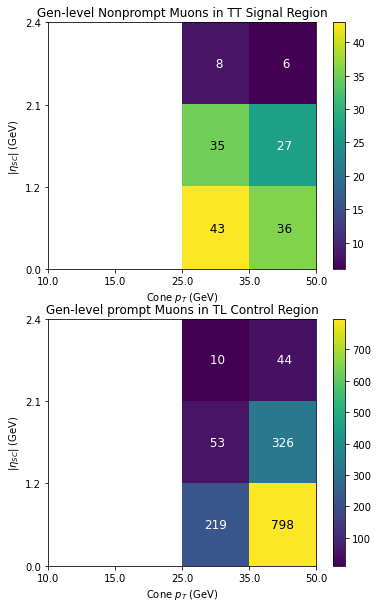

In [5]:
#plot tight and loose counts for muons
fig, ax = plt.subplots(2, 1, figsize = (6,10))

make_yahist(EE_SR.sum("dataset")).plot(show_counts=True, equidistant='xy', ax=ax[0])
ax[0].set_xlabel(r'Cone $p_T$ (GeV)')
ax[0].set_ylabel(r'$\left|\eta_{SC}\right|$ (GeV)')
ax[0].set_title('Gen-level Nonprompt Muons in TT Signal Region')


make_yahist(EE_CR.sum("dataset")).plot(show_counts=True, equidistant='xy', ax=ax[1])
ax[1].set_xlabel(r'Cone $p_T$ (GeV)')
ax[1].set_ylabel(r'$\left|\eta_{SC}\right|$ (GeV)')
ax[1].set_title('Gen-level prompt Muons in TL Control Region')


plt.show()